# Preprocessing of CM2.6 input for air-sea flux calculation

Things to try out to get this to work properly:
- Reduce chunksize to reduce the time filtering needs
- Debug dask killed worker. 
    - These are now entirely due to the filtering.
    - Am I missing an option for dask

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, smooth_inputs_dataset, weighted_coarsen, open_zarr
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.parameters import get_params

In [4]:
fs = gcsfs.GCSFileSystem()
# load global parameters
params = get_params('v0.6.2', test=True)

temp_mapper = fs.get_mapper(params['paths']['CM26']['scratch'])
output_mapper_smooth = fs.get_mapper(params['paths']['CM26']['smooth'])
output_mapper_coarse = fs.get_mapper(params['paths']['CM26']['coarse'])

print(temp_mapper.root)
print(output_mapper_smooth.root)
print(output_mapper_coarse.root)

leap-scratch/jbusecke/scale-aware-air-sea/temp/CM26_v0.6.2test.zarr
leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CM26_smoothed_v0.6.2test.zarr
leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CM26_coarsened_50_v0.6.2test.zarr


In [5]:
# fs.rm(temp_mapper.root, recursive=True)
# fs.rm(output_mapper_smooth.root, recursive=True)

## Set up a legit dask cluster

In [6]:
# import dask
# from dask_gateway import Gateway

# # ## Q: Do we actually need this? 
# # dask.config.set(
# #     {
# #         # make sure the long running filter tasks are not timing out
# #         "distributed.comm.timeouts.tcp": "1440s",
# #         "distributed.comm.timeouts.connect": "1440s",
# #         "distributed.deploy.lost-worker-timeout": "1440s",
# #         "distributed.scheduler.idle-timeout": "1440s"
# #     }
# # )

# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

# options = gateway.cluster_options()
# # options.worker_memory = 50 # Could proabably reduce this to something like 40, but I think that doesnt actually free up space...
# # options.worker_cores = 10 # could probably handle 12 here...10 seemed safe

# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
# )

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# # cluster.adapt(4,40) # need to be careful of the hub memory here for now
# cluster.scale(20) # for testing
# client

from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=3, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 3
Total threads: 12,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38977,Workers: 3
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:38995,Total threads: 4
Dashboard: /user/jbusecke/proxy/39073/status,Memory: 19.62 GiB
Nanny: tcp://127.0.0.1:37583,


## Write out the source data in a temp folder and reload

In [7]:
if not fs.exists(temp_mapper.root):
    print('Recreating temp store from scratch')
    ds_merged_raw  = load_and_combine_cm26(fs, inline_array=True)

    # Only process a small dataset if the version is a test
    if 'test' in params['version']:
        ds_merged_raw = ds_merged_raw.isel(time=slice(0,300))
    
    # FIXME: I did not notice marked improvements with this...so lets not redo this for the next round?
    # # Try to reduce chunksize
    # ds_merged_raw = ds_merged_raw.chunk({'time':1})
    
    to_zarr_split(ds_merged_raw, temp_mapper, split_interval=500)# old 150try 200 next, this is very underpowered.
    
# overwrite with reloaded store
ds_merged = xr.open_dataset(temp_mapper, engine='zarr', chunks={})
ds_merged

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 300)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Coarsen input fields

In [8]:
ds_coarse = weighted_coarsen(
    ds_merged, 
    {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
    'area_t'
)
ds_coarse

<xarray.Dataset>
Dimensions:       (time: 300, yt_ocean: 54, xt_ocean: 72)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    area_t        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

### Sanity checks for the coarsened data

#### Fine and coarse datasets should preserve the global mean tracer values

Text(0.5, 1.0, 'Global weighted SST average')

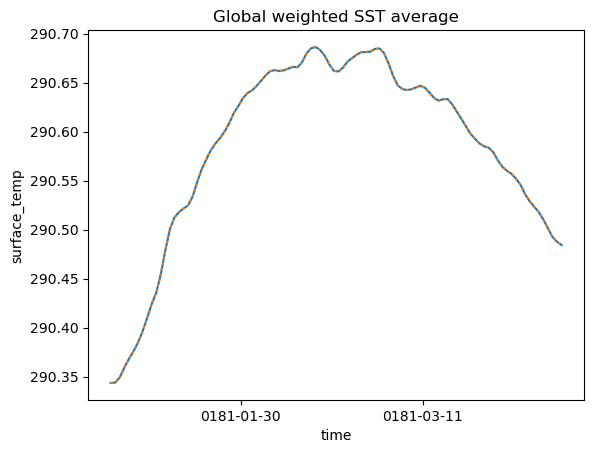

In [21]:
roi = dict(time=slice(0,100))
ds_merged_sample = ds_merged.isel(**roi)
ds_coarse_sample = ds_coarse.isel(**roi)

def w_mean_plot(ds, label, ls):
    da = ds['surface_temp']
    da.weighted(da.area_t).mean(['xt_ocean', 'yt_ocean']).plot(label=label, ls=ls)
    
w_mean_plot(ds_merged_sample, 'fine', '-')
w_mean_plot(ds_coarse_sample, 'coarse', ':')
plt.title('Global weighted SST average')

#### Are eddies visually eliminated?

This is pretty hand wavy still

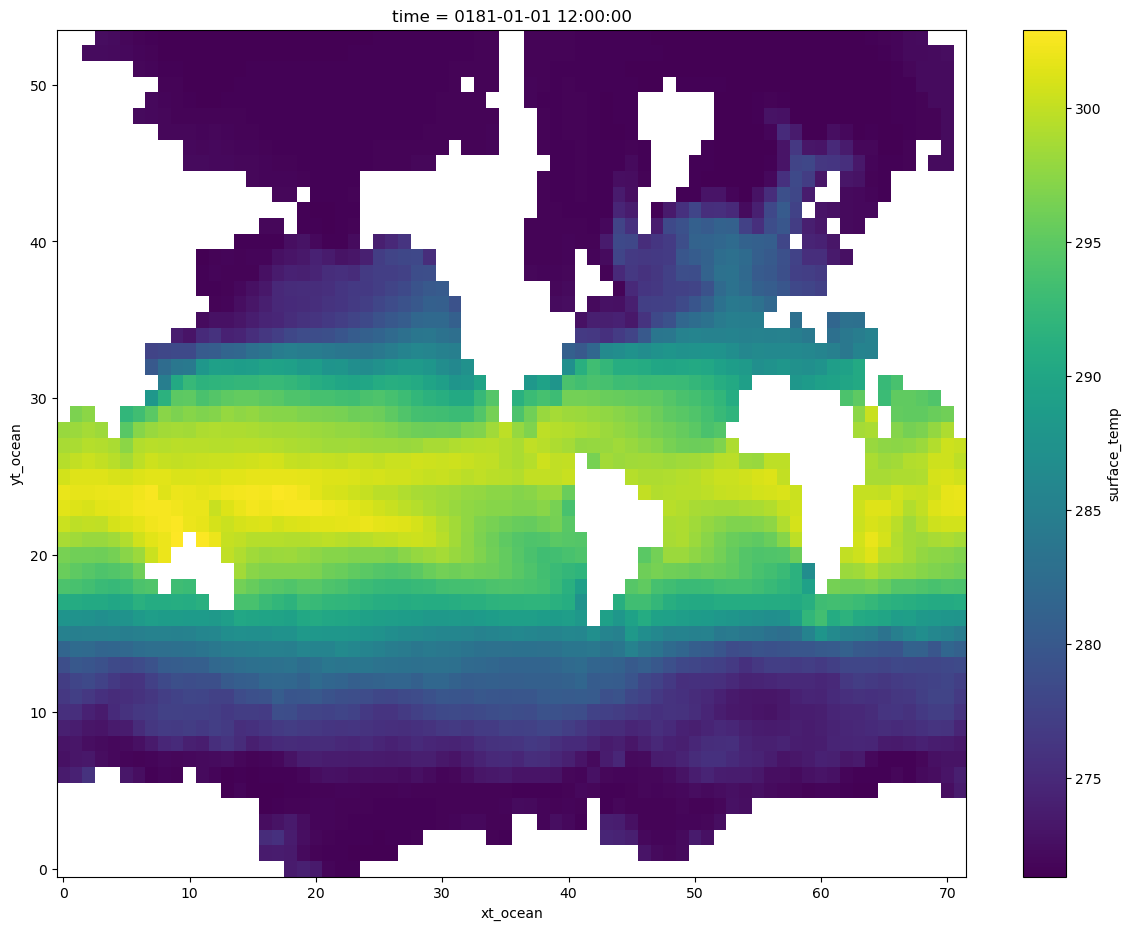

In [22]:
ds_coarse.isel(time=0).surface_temp.plot(size=11)

In [23]:
ds_save_coarse = ds_coarse
print(f"{ds_save_coarse.nbytes/1e9} GB")

0.102676704 GB


### Save out the Coarsened Data

In [24]:
ds_save_coarse.to_zarr(output_mapper_coarse)

In [25]:
ds_reloaded_coarse = xr.open_dataset(output_mapper_coarse, engine='zarr', chunks={}, consolidated=True)
ds_reloaded_coarse

<xarray.Dataset>
Dimensions:       (yt_ocean: 54, xt_ocean: 72, time: 300)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

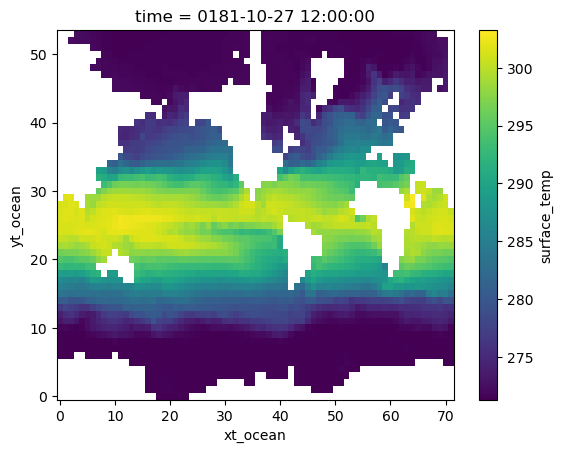

In [28]:
ds_reloaded_coarse.isel(time=-1)['surface_temp'].plot()

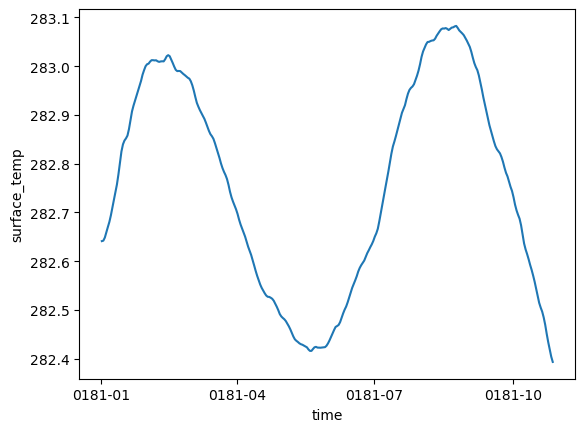

In [29]:
ds_reloaded_coarse.surface_temp.mean(['xt_ocean', 'yt_ocean']).plot()

## Smooth input fields

In [13]:
smooth_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp', 'u_ocean', 'v_ocean', 'u_ref', 'v_ref']

# smooth the whole dataset with the new method
ds_merged_smoothed = smooth_inputs_dataset(
    ds_merged[smooth_vars], 
    ['yt_ocean', 'xt_ocean'], 
    params['filter_scale'], 
    filter_type=params['filter_type'],
)

# add the smoothed variables to the original dataset
for var in smooth_vars:
    ds_merged[var+'_smoothed'] = ds_merged_smoothed[var]
    
# also rebuild a second relative wind from only ocean smoothed velocities
ds_merged['u_relative_smoothed_ocean_only'] = ds_merged['u_ref'] - ds_merged['u_ocean_smoothed']
ds_merged['v_relative_smoothed_ocean_only'] = ds_merged['v_ref'] - ds_merged['v_ocean_smoothed']

ds_merged['u_relative_smoothed_atmos_only'] = ds_merged['u_ref_smoothed'] - ds_merged['u_ocean']
ds_merged['v_relative_smoothed_atmos_only'] = ds_merged['v_ref_smoothed'] - ds_merged['v_ocean']

ds_merged

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 300)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/25)
    q_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp                             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ocean                         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    ...                              ...
    u_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Some sanity checks with the data before large batch save

#### Check that the nanmask is uniform across variables
See https://github.com/ocean-transport/scale-aware-air-sea/issues/46



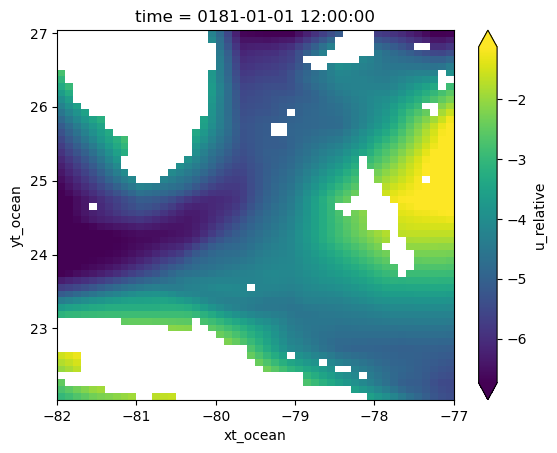

In [ ]:
roi = dict(xt_ocean=slice(-82, -77), yt_ocean=slice(22,27))

plt.figure()
ds_merged['u_relative'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

plt.figure()
ds_merged['u_relative_smoothed'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

plt.figure()
ds_merged['surface_temp_smoothed'].isel(time=0).sel(**roi).plot(robust=True)
plt.show()

In [14]:
# prune dataset for saving
keep_vars = [
    'slp_smoothed', 'surface_temp_smoothed',
    'u_relative_smoothed','v_relative_smoothed',
    'u_relative_smoothed_ocean_only','v_relative_smoothed_ocean_only',
    'u_relative_smoothed_atmos_only','v_relative_smoothed_atmos_only',
    't_ref_smoothed', 'q_ref_smoothed'
]
ds_save_smooth = ds_merged[keep_vars]
print(f"{ds_save_smooth.nbytes/1e12} TB")

0.1171066128 TB


### Save out the Filtered Data

In [ ]:
# if 'test' in params['version']:
#     # only works on small subsets, otherwise see below.
#     to_zarr_split(ds_save_smooth, output_mapper_smooth, split_interval=100) #formerly 1000 split
# else:
#     to_zarr_split(ds_save_smooth, output_mapper_smooth, split_interval=1000) #formerly 1000 split, might need to adjust down?
    

# fs.rm(output_mapper_smooth.root, recursive=True)

to_zarr_split(ds_save_smooth, output_mapper_smooth, split_interval=25) # i used to use 1000 here, but that leads to killed workers
# # FIXME: This is weird. I thought this worked before? It seems this is related to the number of workers... 
# What I do not understand is why the workers are killed? Because they take too long? the memory looks fine, and cpu useage is high
# as expected
# Suspicion: The filter funcs need to all be done in one go? NO, still loosing workers. WTF?
# It kills and then revives some workers untils literally everything BUT the filter func (and the map-store) tasks
# is loaded in memory, which naturally limits the amount of tasks one can chew at once.
# But choosing a small interval is terrible because the last ~3 minute interval usually only a few tasks on a single worker
# And if I remember correctly somehow after they are done, each split interval takes forever to finish
# This is weird
# KilledWorker: Attempted to run task ('open_dataset-90f23e2893ee12db5b4558bcc1da0c49surface_temp-23507b588eca1cca43a4975502cc1fa0', 3, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tls://10.0.30.3:43383. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

Writing to leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/CM26_smoothed_v0.6.2test.zarr ...


  0%|          | 0/11 [00:00<?, ?it/s]

In [4]:
ds_reloaded_smooth = xr.open_dataset(output_mapper_smooth, engine='zarr', chunks={}, consolidated=True)
ds_reloaded_smooth

<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 300)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 018...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    slp_smoothed                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp_smoothed           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref_smoothed                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative_smoothed_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

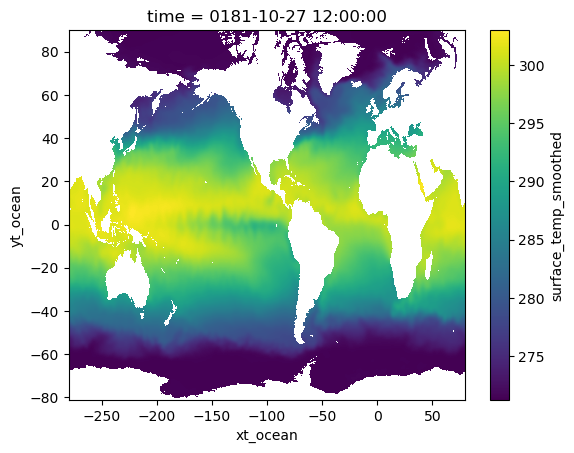

In [5]:
ds_reloaded_smooth.surface_temp_smoothed.isel(time=-1).plot()

In [8]:
da_reloaded_smooth = ds_reloaded_smooth.to_array()
da_reloaded_smooth

<xarray.DataArray (variable: 10, time: 300, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<stack, shape=(10, 300, 2700, 3600), dtype=float32, chunksize=(1, 1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * variable  (variable) object 'q_ref_smoothed' ... 'v_relative_smoothed_oce...
Attributes:
    regrid_method:  bilinear

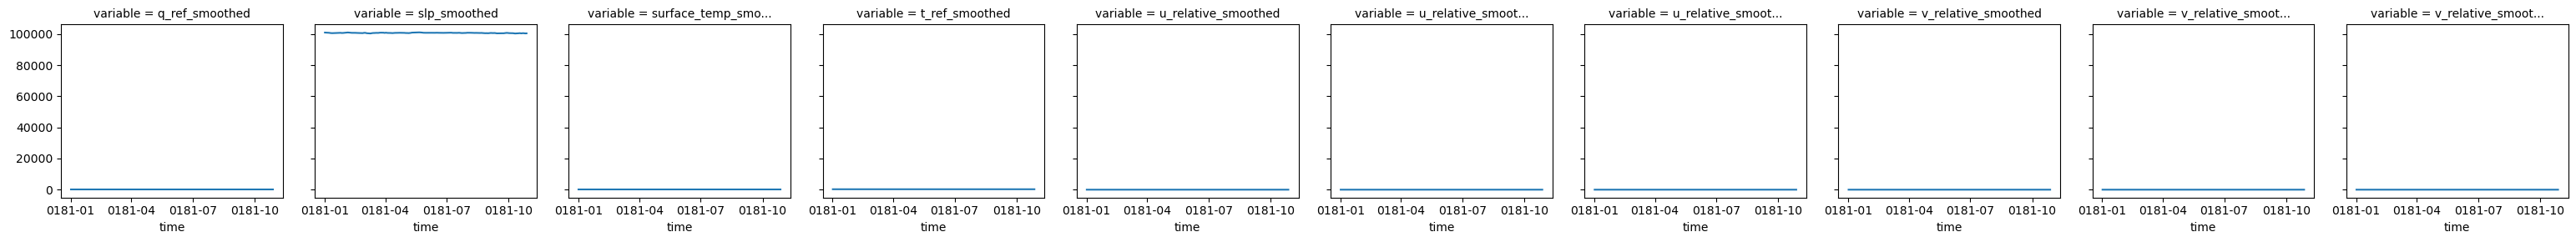

In [9]:
da_reloaded_smooth.mean(['xt_ocean','yt_ocean']).plot(col='variable')

In [ ]:
# client.close()